In [1]:
import tables
import numpy as np
from random import shuffle
from math import ceil
import matplotlib.pyplot as plt

In [2]:
hdf5_path = 'raw3.hdf5'  # Path where dataset.hdf5 file is stored
subtract_mean = True
batch_size = 50
nb_class = 2

In [3]:
hdf5_file = tables.open_file(hdf5_path, mode='r')
# subtract the training mean
if subtract_mean:
    mm = hdf5_file.root.train_mean[0]
    mm = mm[np.newaxis, ...]

# Total number of samples
train_data = np.array(hdf5_file.root.train_img)
train_label = np.array(hdf5_file.root.train_labels)

test_data = np.array(hdf5_file.root.test_img)
test_label = np.array(hdf5_file.root.test_labels)

val_data = np.array(hdf5_file.root.val_img)
val_label = np.array(hdf5_file.root.val_labels)

print('train data:',train_data.shape,' train_label',train_label.shape)
print('test_data:',test_data.shape,' test_label:',test_label.shape)
print(test_label)
print('val_data:',val_data.shape,' val_label:',val_label.shape)

train data: (103, 128, 128, 3)  train_label (103,)
test_data: (51, 128, 128, 3)  test_label: (51,)
[1 1 0 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 0]
val_data: (51, 128, 128, 3)  val_label: (51,)


In [4]:
from keras.utils import np_utils

# one-hot encode the labels
num_classes = len(np.unique(train_label))
train_label = np_utils.to_categorical(train_label, num_classes)
test_label = np_utils.to_categorical(test_label, num_classes)
val_label = np_utils.to_categorical(val_label, num_classes)

# print shape of training set
print('num_classes:', num_classes)

# print number of training, validation, and test images
print(train_label.shape, 'train samples')
print(test_label.shape, 'test samples')
print(test_label)
print(val_label.shape, 'validation samples')


num_classes: 2
(103, 2) train samples
(51, 2) test samples
[[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]
(51, 2) validation samples


In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='tanh'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='tanh'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='tanh'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

In [6]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [7]:
from keras.callbacks import ModelCheckpoint   

# train the model
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
hist = model.fit(train_data, train_label, batch_size=None, epochs=80,
          validation_data=(val_data, val_label),callbacks=[checkpointer], 
          verbose=1, shuffle=True)

Epoch 1/80
4/4 [==============================] - ETA: 0s - loss: 6.2023 - accuracy: 0.4757
Epoch 1: val_loss improved from inf to 2.54820, saving model to model.weights.best.hdf5
4/4 [==============================] - 4s 597ms/step - loss: 6.2023 - accuracy: 0.4757 - val_loss: 2.5482 - val_accuracy: 0.7451
Epoch 2/80
4/4 [==============================] - ETA: 0s - loss: 1.7030 - accuracy: 0.8058
Epoch 2: val_loss improved from 2.54820 to 0.72039, saving model to model.weights.best.hdf5
4/4 [==============================] - 2s 503ms/step - loss: 1.7030 - accuracy: 0.8058 - val_loss: 0.7204 - val_accuracy: 0.7451
Epoch 3/80
4/4 [==============================] - ETA: 0s - loss: 2.5492 - accuracy: 0.5922
Epoch 3: val_loss did not improve from 0.72039
4/4 [==============================] - 1s 356ms/step - loss: 2.5492 - accuracy: 0.5922 - val_loss: 5.4800 - val_accuracy: 0.7451
Epoch 4/80
4/4 [==============================] - ETA: 0s - loss: 2.8850 - accuracy: 0.7184
Epoch 4: val_loss 

Epoch 30/80
4/4 [==============================] - ETA: 0s - loss: 0.3784 - accuracy: 0.8155
Epoch 30: val_loss did not improve from 0.42211
4/4 [==============================] - 1s 343ms/step - loss: 0.3784 - accuracy: 0.8155 - val_loss: 0.5944 - val_accuracy: 0.7451
Epoch 31/80
4/4 [==============================] - ETA: 0s - loss: 0.4817 - accuracy: 0.8058
Epoch 31: val_loss did not improve from 0.42211
4/4 [==============================] - 1s 330ms/step - loss: 0.4817 - accuracy: 0.8058 - val_loss: 0.4241 - val_accuracy: 0.7647
Epoch 32/80
4/4 [==============================] - ETA: 0s - loss: 0.4496 - accuracy: 0.7864
Epoch 32: val_loss did not improve from 0.42211
4/4 [==============================] - 2s 493ms/step - loss: 0.4496 - accuracy: 0.7864 - val_loss: 0.4351 - val_accuracy: 0.8235
Epoch 33/80
4/4 [==============================] - ETA: 0s - loss: 0.4160 - accuracy: 0.7864
Epoch 33: val_loss improved from 0.42211 to 0.40764, saving model to model.weights.best.hdf5
4/4 

Epoch 59/80
4/4 [==============================] - ETA: 0s - loss: 0.1765 - accuracy: 0.9320
Epoch 59: val_loss did not improve from 0.29647
4/4 [==============================] - 2s 405ms/step - loss: 0.1765 - accuracy: 0.9320 - val_loss: 0.4510 - val_accuracy: 0.7647
Epoch 60/80
4/4 [==============================] - ETA: 0s - loss: 0.2097 - accuracy: 0.8641
Epoch 60: val_loss did not improve from 0.29647
4/4 [==============================] - 2s 397ms/step - loss: 0.2097 - accuracy: 0.8641 - val_loss: 0.4047 - val_accuracy: 0.7647
Epoch 61/80
4/4 [==============================] - ETA: 0s - loss: 0.1523 - accuracy: 0.9417
Epoch 61: val_loss did not improve from 0.29647
4/4 [==============================] - 2s 401ms/step - loss: 0.1523 - accuracy: 0.9417 - val_loss: 0.3036 - val_accuracy: 0.8431
Epoch 62/80
4/4 [==============================] - ETA: 0s - loss: 0.1698 - accuracy: 0.9806
Epoch 62: val_loss did not improve from 0.29647
4/4 [==============================] - 2s 402ms/s

In [8]:
model.load_weights('model.weights.best.hdf5')

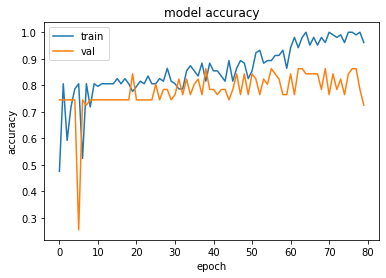

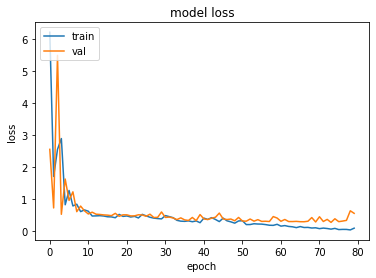

In [9]:
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [10]:
score = model.evaluate(test_data, test_label, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.843137264251709


In [11]:
import pandas as pd

print(test_label)
predictions = model.predict(test_data)
predictions = pd.DataFrame(predictions)
print(predictions.idxmax(axis=1))

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]
0     1
1     1
2     1
3     0
4     1
5     1
6     1
7     1
8     1
9     0
10    1
11    1
12    0
13    0
14    1
15    0
16    1
17    1
18    1
19    1
20    0
21    1
22    1
23    1
24    1
25    0
26    0
27    1
28    1
29    1
30    1
31    1
32    0
33    1
34    1
35    1
36    1
37    1
38    1
39    1
40    0
41    0
42    1
43    1
44    1
45    1
46    1
47    1
48    1
49    1
50    0
dtype: int64


In [12]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [13]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[1 1 1 0 1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1
 1 1 1 0 0 1 1 1 1 1 1 1 1 0]
Confusion matrix, without normalization
[[ 8  4]
 [ 4 35]]


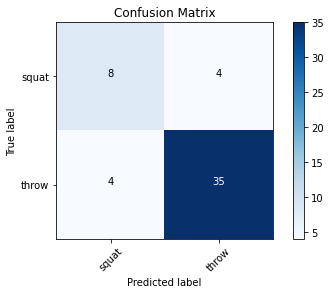

In [15]:
tests = model.predict(test_data)
tests = np.argmax(tests,axis = 1) 
print(tests)
cm_plot_labels = ['squat','throw']

cm = confusion_matrix(y_true=np.argmax(test_label,axis = 1), y_pred=tests)
plot_confusion_matrix(cm=cm, classes=cm_plot_labels,title='Confusion Matrix')